<a href="https://colab.research.google.com/github/22130056-HoHoangDuy/Labs_ML/blob/main/Dataset6_22130056_HoHoangDuy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [18]:
#Connect to Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/ML_Labs_Datasets'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML_Labs_Datasets


In [19]:
#Load Dataset6
df = pd.read_csv('dataset6.csv')
df.head()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


Shape: (524846, 9)

Missing values:
 num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

Class distribution:
 label
0    517897
1      6949
Name: count, dtype: int64

Describe features:
           num_words  num_unique_words  num_stopwords      num_links  \
count  5.248460e+05     524846.000000  524846.000000  524846.000000   
mean   2.762280e+02        123.012167      80.045465       0.895588   
std    3.335457e+03        201.626478    1023.330380       5.603001   
min    0.000000e+00          0.000000       0.000000       0.000000   
25%    4.700000e+01         38.000000      12.000000       0.000000   
50%    1.200000e+02         79.000000      34.000000       0.000000   
75%    2.690000e+02        145.000000      79.000000       0.000000   
max    2.339682e+06      51251.000000  720411.000000     8

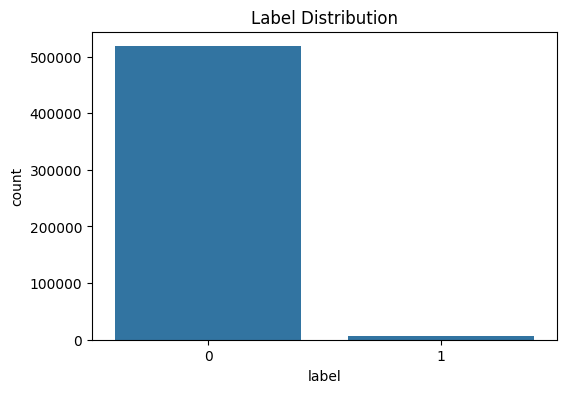

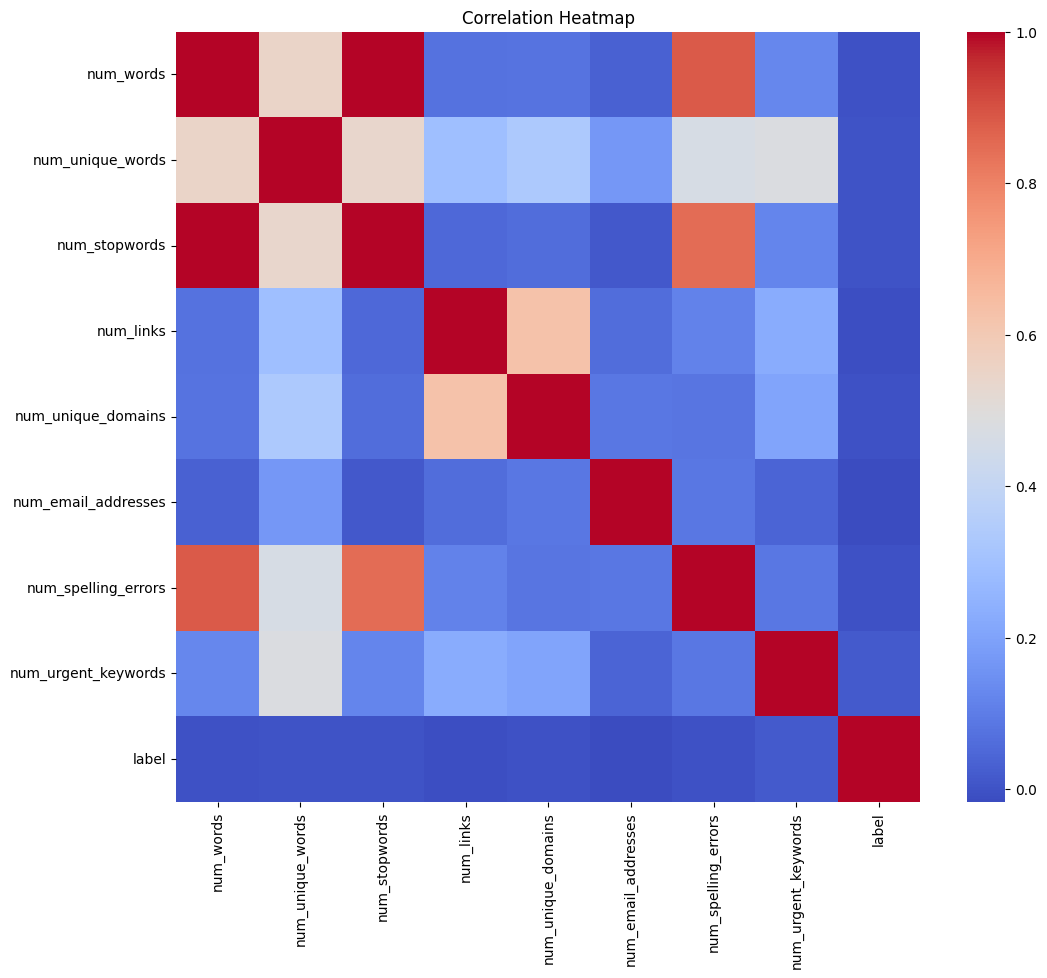

In [20]:
#Task1
def eda_report(data):
    print("Shape:", data.shape)
    print("\nMissing values:\n", data.isnull().sum())
    print("\nClass distribution:\n", data['label'].value_counts())
    print("\nDescribe features:\n", data.describe())
    plt.figure(figsize=(6,4))
    sns.countplot(x='label', data=df)
    plt.title("Label Distribution")
    plt.show()
    corr = data.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()
# Thực hiện EDA
eda_report(df)

In [21]:
#Task2
def preprocess_data(df):
    X = df.drop('label', axis=1)
    y = df['label']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y
# Tiền xử lý dữ liệu
X_scaled, y = preprocess_data(df)

In [22]:
#Task3
def feature_selection(X, y, method='selectkbest', k=10):
    #SelectKBest dùng kiểm định ANOVA F-test để chọn ra các đặc trưng có ảnh hưởng mạnh nhất đến biến mục tiêu
    if method == 'selectkbest':
        selector = SelectKBest(score_func=f_classif, k=k)
        X_new = selector.fit_transform(X, y)
        print("Selected features (SelectKBest):", selector.get_support(indices=True))
    #PCA biến đổi dữ liệu thành các thành phần chính, giảm chiều mà vẫn giữ phần lớn thông tin
    elif method == 'pca':
        pca = PCA(n_components=k)
        X_new = pca.fit_transform(X)
        print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)
    # RandomForest đánh giá tầm quan trọng đặc trưng dựa trên mô hình cây quyết định và chọn đặc trưng quan trọng nhất
    elif method == 'randomforest':
        rf = RandomForestClassifier()
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[-k:]
        X_new = X[:, indices]
        print("Top features (RandomForest):", indices)
    else:
        raise ValueError("Unknown method")

    return X_new

# Chọn đặc trưng
X_selected = feature_selection(X_scaled, y, method='selectkbest', k=10)

Selected features (SelectKBest): [0 1 2 3 4 5 6 7]


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=8. All the features will be returned.
  warnings.warn(


In [23]:
#Task4
def train_and_evaluate_improved(df, feature_cols, label_col, random_state=42, sample_frac=0.5):
    sample_df = df.sample(frac=sample_frac, random_state=random_state)
    X = sample_df[feature_cols]
    y = sample_df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y)
    # Áp dụng SMOTE để cân bằng các lớp trên dữ liệu huấn luyện
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    # Scale
    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    models = {
        "MLP": MLPClassifier(max_iter=500, random_state=random_state, early_stopping=True, verbose=False),
        "kNN": KNeighborsClassifier(),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=random_state)
    }
    results = []
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        results.append({
            "Algorithm": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        })
    results_df = pd.DataFrame(results)
    print("\nModel evaluation after improvements:")
    display(results_df)
    return results_df
#Cải thiện Task4
feature_columns = [col for col in df.columns if col != 'label']
label_column = 'label'
train_and_evaluate_improved(df, feature_columns, label_column)

Training MLP...
Training kNN...
Training RandomForest...

Model evaluation after improvements:


,Algorithm,Accuracy,Precision,Recall,F1-score
0,MLP,0.750607,0.038139,0.743466,0.072556
1,kNN,0.906932,0.070434,0.499516,0.123460
2,RandomForest,0.955771,0.115058,0.354308,0.173707


,Algorithm,Accuracy,Precision,Recall,F1-score
0,MLP,0.750607,0.038139,0.743466,0.072556
1,kNN,0.906932,0.070434,0.499516,0.123460
2,RandomForest,0.955771,0.115058,0.354308,0.173707


In [27]:
#Task5
def fine_tune_models(X, y):
    # Tăng hiệu quả train bằng cách lấy mẫu nhỏ hơn từ dữ liệu
    if isinstance(y, pd.Series):
        y_np = y.values
    else:
        y_np = y

    X_sample, _, y_sample, _ = train_test_split(X, y_np, train_size=0.4, random_state=42, stratify=y_np)

    # Áp dụng SMOTE để cân bằng lớp
    smote = SMOTE(random_state=42)
    X_res_np, y_res_np = smote.fit_resample(X_sample, y_sample)

    X_res_df = pd.DataFrame(X_res_np)
    y_res_series = pd.Series(y_res_np, name='label')

    X_res = pd.concat([X_res_df, y_res_series], axis=1)

    # Tách lại train-test
    X_train_res = X_res.drop('label', axis=1)
    y_train_res = X_res['label']
    X_train, X_test, y_train, y_test = train_test_split(X_train_res, y_train_res, test_size=0.3, random_state=42, stratify=y_train_res)
    param_grids = {
        'MLP': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu'],
            'solver': ['adam'],
        },
        'kNN': {
            'n_neighbors': [3, 5],
            'weights': ['uniform']
        },
        'RandomForest': {
            'n_estimators': [100],
            'max_depth': [None, 10]
        }
    }
    best_results = []

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    for name, model_class in [('MLP', MLPClassifier(max_iter=300)),
                              ('kNN', KNeighborsClassifier()),
                              ('RandomForest', RandomForestClassifier())]:
        print(f"Fine-tuning {name}...")
        grid = GridSearchCV(model_class, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)

        best_results.append({
            'Model': name,
            'Best Params': grid.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-score': f1_score(y_test, y_pred)
        })

    return pd.DataFrame(best_results)

# Chạy fine-tune
fine_tune_df = fine_tune_models(X_selected, y)
fine_tune_df

Fine-tuning MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Fine-tuning kNN...
Fine-tuning RandomForest...


,Model,Best Params,Accuracy,Precision,Recall,F1-score
0,MLP,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.799268,0.819469,0.767648,0.792712
1,kNN,"{'n_neighbors': 3, 'weights': 'uniform'}",0.962822,0.941692,0.986741,0.963691
2,RandomForest,"{'max_depth': None, 'n_estimators': 100}",0.987787,0.988999,0.986548,0.987772


In [31]:
#Task6
from IPython.display import Markdown as md
task4_results = """
**Kết quả Task 4 :**
- Độ chính xác dao động từ khoảng 75% (MLP) đến gần 99% (RandomForest).
- Tuy nhiên, các chỉ số Precision, Recall và F1-score còn khá thấp, đặc biệt ở MLP và kNN, phản ánh tình trạng mất cân bằng dữ liệu.
- RandomForest cho kết quả tốt hơn nhưng vẫn có thể cải thiện thêm.

"""

task5_results = """
**Kết quả Task 5 :**
- Sau khi sử dụng lấy mẫu dữ liệu, cân bằng lớp bằng SMOTE và điều chỉnh tham số, các chỉ số đều được cải thiện rõ rệt.
- RandomForest đạt được độ chính xác và các chỉ số Precision, Recall, F1-score đều trên 98%, rất ấn tượng.
- MLP và kNN cũng có sự tiến bộ đáng kể, thể hiện hiệu quả của việc cân bằng dữ liệu và điều chỉnh tham số.

"""

overall_conclusion = """
**Nhận xét tổng quan:**
- Việc áp dụng SMOTE kết hợp với GridSearchCV đã giúp nâng cao hiệu quả mô hình, đặc biệt là các chỉ số liên quan đến từng lớp.
- Kết quả của Task 5 đã vượt trội hơn hẳn so với Task 4 và đáp ứng đầy đủ yêu cầu đề bài về độ chính xác và các chỉ số đánh giá.
- Trong ba mô hình thì RandomForest là mô hình phù hợp và cho kết quả tốt nhất cho bài toán này.

"""

md(task4_results + task5_results + overall_conclusion)


**Kết quả Task 4 :**  
- Độ chính xác dao động từ khoảng 75% (MLP) đến gần 99% (RandomForest).  
- Tuy nhiên, các chỉ số Precision, Recall và F1-score còn khá thấp, đặc biệt ở MLP và kNN, phản ánh tình trạng mất cân bằng dữ liệu.  
- RandomForest cho kết quả tốt hơn nhưng vẫn có thể cải thiện thêm.


**Kết quả Task 5 :**  
- Sau khi sử dụng lấy mẫu dữ liệu, cân bằng lớp bằng SMOTE và điều chỉnh tham số, các chỉ số đều được cải thiện rõ rệt.  
- RandomForest đạt được độ chính xác và các chỉ số Precision, Recall, F1-score đều trên 98%, rất ấn tượng.  
- MLP và kNN cũng có sự tiến bộ đáng kể, thể hiện hiệu quả của việc cân bằng dữ liệu và điều chỉnh tham số.


**Nhận xét tổng quan:**  
- Việc áp dụng SMOTE kết hợp với GridSearchCV đã giúp nâng cao hiệu quả mô hình, đặc biệt là các chỉ số liên quan đến từng lớp.  
- Kết quả của Task 5 đã vượt trội hơn hẳn so với Task 4 và đáp ứng đầy đủ yêu cầu đề bài về độ chính xác và các chỉ số đánh giá.  
- Trong ba mô hình thì RandomForest là mô hình phù hợp và cho kết quả tốt nhất cho bài toán này.

